# ESO-archive query and data download

This script will access the eso-archive database and extract the metadata for the processed and raw data. Both of their identifiers will be cross matched to each other be able to separate them, and later download only the required data to optimize download duration and memory consumption.  

This script contains a lot of function which help in the extracting the data as an initial phase. There is an library called **tools** which contains packages that will help to make the code run smoother. In other words, the querying is done under the hood, but the data-wrangling is visible in the script. 

 ## Import packages

Note: If you get an error for *astronomical* third party missing packages or any other, install them, since this code assumes you have them all, which are:

1. pyvo
2. astropy
3. matplotlib
4. datetime
5. pandas
6. numpy
7. math
8. pathlib
9. unlzw3 
10. os
11. warnings
12. urllib
13. astroquery
14. sys

In [1]:
#Imported external functions
from tools.table_extraction import eso_import, decode_pandas, search_simbad_names, \
get_simbad_names, query_gaia_id, download_raw, download_process, cross_match,demo_query

Could not import regions, which is required for some of the functionalities of this module.
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


*You can see that a connection was made to querying services. They are called TAP services and used ADQL (Astronomical Database Query Language) to do the queries.*

In [2]:
#required packages for this code
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from astropy.io import fits
from astropy.table import Table
import numpy as np
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime

#fixing pandas option for visualizing in this notebook
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

#save file anotation: extract the run date of a file and annotates saved csvs
note = str(datetime.now()) 

 ## Exploring eso-archive database

Check instrument documentation first for processed and raw data columns. **demo_query** show how the top 100 rows of the original databases. For the raw database which named in the eso archive is **dbo.raw**, and the **ivoa.ObsCore** for the processed data. We will later select whatever we want from the database and rename this columns for our use. Some of the columns will be used to extract information from them to generate new columns. The reason is that some identifier are within a string name and note as an individual column which can be used for filtering. 

In [3]:
demo_query('dbo.raw').sample() 

,access_url,datalink_url,date_obs,dec,dec_pnt,det_chip1id,det_chop_ncycles,det_dit,det_expid,det_ndit,dp_cat,dp_id,dp_tech,dp_type,ecl_lat,ecl_lon,exp_start,exposure,filter_path,gal_lat,gal_lon,grat_path,gris_path,ins_mode,instrument,last_mod_date,mjd_obs,ob_id,ob_name,object,obs_mode,origfile,period,pi_coi,prog_id,prog_title,prog_type,ra,ra_pnt,release_date,slit_path,target,tel_airm_end,tel_airm_start,tel_alt,tel_ambi_fwhm_end,tel_ambi_fwhm_start,tel_ambi_pres_end,tel_ambi_pres_start,tel_ambi_rhum,tel_az,telescope,tpl_expno,tpl_id,tpl_name,tpl_nexp,tpl_seqno,tpl_start
11,https://dataportal.eso.org/dataportal_new/file/AMBER.2007-07-08T13:56:10.293,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?AMBER.2007-07-08T13:56:10.293,2007-07-08T13:56:10.2936,-596.523236,NaN,,<NA>,1,<NA>,20,CALIB,AMBER.2007-07-08T13:56:10.293,INTERFEROMETRY,3P2V,NaN,NaN,2007-07-08T13:56:10Z,20.0,,NaN,NaN,GHR,"NAR_SLT,3T_K",3Tstd_High_K_1_2.095,AMBER,2010-11-30T09:20:26Z,54289.582031,200164939,AMBER-Daily-HC,3P2V,s,AMBER_3TSTD_CAL189_0141.fits,<NA>,AMBER TEAM,60.A-9054(A),AMBER TEST ACCOUNT,0,-596.523236,NaN,2007-07-08T13:56:10Z,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT_SPECIFIED,7,AMBER_3Tstd_cal_p2vmColposInit,AMBER P2VM calibration,15,10,2007-07-08T13:50:41


In [4]:
demo_query('ivoa.ObsCore').tail(n=5)

,abmaglim,access_estsize,access_format,access_url,bib_reference,calib_level,dataproduct_subtype,dataproduct_type,dp_id,em_max,em_min,em_res_power,em_xel,facility_name,filter,gal_lat,gal_lon,instrument_name,multi_ob,n_obs,o_calib_status,o_ucd,obs_collection,obs_creator_did,obs_creator_name,obs_id,obs_publisher_did,obs_release_date,obs_title,obstech,p3orig,pol_states,pol_xel,proposal_id,publication_date,s_dec,s_fov,s_pixel_scale,s_ra,s_region,s_resolution,s_xel1,s_xel2,snr,t_exptime,t_max,t_min,t_resolution,t_xel,target_name
95,NaN,2450,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ADP.2020-06-12T16:16:16.654,,2,,spectrum,ADP.2020-06-12T16:16:16.654,4.999720e-07,3.732020e-07,40970.0,85395,ESO-VLT-U2,,71.249291,351.924615,UVES,S,1,absolute,,UVES,ivo://eso.org/origfile?UV_SFLX_1037490_2014-06-06T03:29:43.285_BLU437d2_1x1_10.fits,"SBORDONE, L.",1037490,ivo://eso.org/ID?ADP.2020-06-12T16:16:16.654,2015-06-06T04:51:42Z,SDSSJ134922+140736_1037490_2014-06-06T03:29:43.285_BLU437d2_1x1_10,ECHELLE,IDP,,<NA>,093.D-0136(A),2020-10-20T09:55:54Z,14.12665,0.00028,NaN,207.345286,POSITION J2000 207.345286 14.12665,NaN,<NA>,<NA>,10.9,3600.002,56814.187307,56814.145640,3600.002880,<NA>,SDSS J134922+140736
96,NaN,2450,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ADP.2020-06-12T16:16:16.657,,2,,spectrum,ADP.2020-06-12T16:16:16.657,4.999720e-07,3.732020e-07,40970.0,85395,ESO-VLT-U2,,71.249291,351.924615,UVES,S,1,absolute,,UVES,ivo://eso.org/origfile?UV_SFLX_1037486_2014-06-06T01:24:42.643_BLU437d2_1x1_10.fits,"SBORDONE, L.",1037486,ivo://eso.org/ID?ADP.2020-06-12T16:16:16.657,2015-06-06T02:40:38Z,SDSSJ134922+140736_1037486_2014-06-06T01:24:42.643_BLU437d2_1x1_10,ECHELLE,IDP,,<NA>,093.D-0136(A),2020-10-20T09:55:54Z,14.12665,0.00028,NaN,207.345286,POSITION J2000 207.345286 14.12665,NaN,<NA>,<NA>,19.5,3600.002,56814.100494,56814.058827,3600.002016,<NA>,SDSS J134922+140736
97,NaN,5299,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ADP.2020-06-12T16:16:16.660,,2,,spectrum,ADP.2020-06-12T16:16:16.660,9.464060e-07,5.654740e-07,42310.0,185872,ESO-VLT-U2,,71.249291,351.924615,UVES,S,1,absolute,,UVES,ivo://eso.org/origfile?UV_SFLX_1037484_2014-06-06T00:20:02.297_RED760d2_1x1_10.fits,"SBORDONE, L.",1037484,ivo://eso.org/ID?ADP.2020-06-12T16:16:16.660,2015-06-06T01:37:19Z,SDSSJ134922+140736_1037484_2014-06-06T00:20:02.297_RED760d2_1x1_10,ECHELLE,IDP,,<NA>,093.D-0136(A),2020-10-20T09:55:54Z,14.12665,0.00028,NaN,207.345286,POSITION J2000 207.345286 14.12665,NaN,<NA>,<NA>,13.0,3599.998,56814.055582,56814.013915,3599.997696,<NA>,SDSS J134922+140736
98,NaN,6203,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ADP.2020-06-12T16:16:16.664,,2,,spectrum,ADP.2020-06-12T16:16:16.664,4.999720e-07,3.732020e-07,40970.0,85395,ESO-VLT-U2,,15.795707,353.097940,UVES,S,1,absolute,,UVES,ivo://eso.org/origfile?UV_SOBF_1037102_2014-06-06T04:45:13.938_BLU437d2_1x1_10.fits,"FELTZING, SOFIA",1037102,ivo://eso.org/ID?ADP.2020-06-12T16:16:16.664,2015-06-06T05:10:33Z,ToO_BstarC_1037102_2014-06-06T04:45:13.938_BLU437d2_1x1_10,ECHELLE,IDP,,<NA>,093.B-0700(C),2020-10-20T09:55:54Z,-25.11556,0.00028,NaN,247.551945,POSITION J2000 247.551945 -25.11556,NaN,<NA>,<NA>,208.4,40.007,56814.201023,56814.198078,254.479968,<NA>,ToO_BstarC
99,NaN,3778,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ADP.2020-06-12T16:16:16.674,,2,,spectrum,ADP.2020-06-12T16:16:16.674,6.835270e-07,4.726230e-07,66320.0,131852,ESO-VLT-U2,,2.477489,311.046151,UVES,S,1,absolute,,UVES,ivo://eso.org/origfile?UV_SFLX_1036549_2014-06-05T23:26:07.988_RED580d1_1x1_06.fits,"JONES, DAVID",1036549,ivo://eso.org/ID?ADP.2020-06-12T16:16:16.674,2015-06-06T00:11:16Z,SuWt2_1036549_2014-06-05T23:26:07.988_RED580d1_1x1_06,ECHELLE,IDP,,<NA>,593.D-0037(A),2020-10-20T09:55:54Z,-59.37763,0.00017,NaN,208.930943,POSITION J2000 208.930943 -59.37763,NaN,<NA>,<NA>,109.1,1

## Data gathering parameter selection

In [5]:
#Select search type
search_type = 'by_name' #'by_coordinates' or 'by_name'

#If you select 'by_name', target name
TARGET_SESAME_NAME = "M 67"

#if  youspecific target coordinate
target_ra = None
target_dec = None

If you choose **by_name**, name will be resolved by the SESAME astronomical service and return coordinate values automatically, and the script will ignore the user defined coordinates. If you choose **by_coordinates** the script doesn't resolve the name and directly uses the passed coordinates.  

**Note:** *But is recommended to always select the name, since the downloaded files will be saved by that name.*

In [6]:
# square window search size in degrees 
RESOLVE_WINDOW =  0.01 #in degress  

Usually ADQL has an option for searching within a circle and i7t has a special function for it. But the eso-archive doesn't support it and generates a manual calculation for it in their system. In this script, a square window is used centered by the coordinates of the resolved object. With th length of the side of the square double the value of **RESOLVE_WINDOW**. 

In [7]:
#select instrument name which matches the database
INSTRUMENT_NAMES = ['UVES'] 

You can choose more than one instrument, and if you want all the instruments, just type an empty list:  **INSTRUMENT_NAMES = [ ]** 

In [8]:
#select the type of raw data
PRODUCT_TYPE_RAW = ["SCIENCE"]

Choose all or as many as you want: options are 
1. ACQUISITION
2. CALIB
3. SCIENCE
4. leave it as [ ] or 3 of them for all files

Note that if you choose only CALIB, ACQUISITION, or both, the script will **not retrieve** raw SCIENCE and the processed data will not be cross match with the raw files and will be excluded.  

In [9]:
#observation dates
obs_night_beg = None
obs_night_end = None

If you pass 'None' or 'False' to the observation dates, all of the dates will be returned for the data and they will not be filtered. The format of the date to be used is: 
* obs_night_beg = '1800-01-01T00:00:00.0000'
* obs_night_end = '3000-12-31T12:59:59.9999' 

In [10]:
#cross match search radius
rad = 5 #arcsec 

This script also cross matches with Simbad, 2MASS, and Gaia erdr3 databases. The above variable specifies the vicinity of the cross match to be done. 

## Data filtering parameter selection

In the eso-archive metadata, the type of the raw data are mentioned and columns do exits and we queried based on the previous specification using the **PRODUCT_TYPE_RAW**. But for the processed data, the information in found in specific columns within group of strings. After reading the documentation and getting familiar with the eso-archive nomenclature system, here we generate rows based on those standards to generate new columns that can help us do further grouping/filtering operations.  

To create these new columns, the user can pass a dictionary(JSON-like object) called **PRODUCT_TYPE_PROCESS**, where the keys are created associated to a list of strings. These keys will be the new column values which are associated to the list of string items found in the **obs_creator_id** column of the processed eso-archive database. 

If the condition is not satisfied and these string are not found in the rows, it return an N/A value. 

In [11]:
#the dictionary that will create columns based on these list of strings 
PRODUCT_TYPE_PROCESS = {'reduced':['SFLX','SRED'],
                        'stacked':['SOBF','SOBR']}

The same procedure is also done to create the arm wavebands (red/blue). For the waveband of processed database it creates a new column using the **obs_creator_id** column, and for the raw data, it uses the columns **orig_file**. It is required to check the documentation to understand what are indicators for each instrument. The values below are associated to the UVES. 

In [12]:
#the dictionary that will create columns based on these list of strings 
WAVEBAND={'red':['FLAMES','DIC1R','DIC2R','_RED'],
          'blue': ['DIC1B','DIC2B','BLUE','_BLU']}

In [13]:
#selection criteria based on the above created columns
process_product_selection = ['reduced','stacked']
wave_selection = ['red']

At this point, the user can select the required type of product and waveband. 

## Data saving parameters

Here the user specifies where the data will be saved. In this case, the script uses the previously defined **TARGET_SESAME_NAME** to save the file, but the users can always select their preference. 

In [14]:
#creating saving directory
save_directory_global = "/home/sako/Desktop/"+ TARGET_SESAME_NAME

In [15]:
#check if files exits, else creates new ones
save_directory_raw = save_directory_global +"/Raw/"
save_directory_process = save_directory_global +"/Processed/"
if os.path.exists(save_directory_global): 
    print(f'[INFO]:{save_directory_global} exists')
else: 
    print(f'[INFO]:creating {save_directory_global}')
    os.mkdir(save_directory_global)
    os.mkdir(save_directory_process)
    os.mkdir(save_directory_raw)

[INFO]:/home/sako/Desktop/M 67 exists


## FITS file header keys

If the user knows the keys of the headers in the processed or raw files, they could be added and attached to the summaries of the downloaded files.

In [ ]:
fits_items = ['ESO INS GRAT1 WLEN',
              'ESO INS GRAT2 WLEN', 
              'ESO DET WIN1 BINX' ,
              'ESO DET WIN1 BINY' ,
              'ESO INS SLIT3 WID' ,
              'ESO INS SLIT1 WID']

mos_table_name = 'OzPoz_table'
mos_type =  'U                   ' #they have a lot of spaces 

## Importing metadata from eso-archive

Based on the **search_type** selection the coordinates are generated. To handle astronomical coordinates, the SkyCoord package is used. 

In [16]:
if search_type == 'by_name': coordinates = SkyCoord.from_name(TARGET_SESAME_NAME)
if search_type =='by_coordinates': coordinates = SkyCoord(target_ra*u.deg, target_dec*u.deg, frame='icrs')

**eso_import** is where the most of the query happens. The previously defined user parameters are passed to it and a pandas dataframe is returned.  

In [17]:
complete_query=eso_import(coordinates,
               RESOLVE_WINDOW,
               instrument_name = INSTRUMENT_NAMES,
               product_type_raw = PRODUCT_TYPE_RAW,
               waveband = WAVEBAND,
               product_type_process = PRODUCT_TYPE_PROCESS)

[INFO]: Target = 
 <SkyCoord (ICRS): (ra, dec) in deg
    (132.825, 11.8)>
[INFO]: Radius = 0.01
[INFO]: RAW retrieved = 9
[INFO]: PROCESSED retrieved = 3


Here you can see several differences between the original returned metadata. Where the raw and the processed data are combined based on a primary key **pk**. There are now separated indicator and descriptors for both of them while being matched. In addition the observation dates are timestamps and can be manipulated to select the required ones, unlike the original metadata which returns dates as strings. 

In [18]:
complete_query.sort_values("product_type_raw",ascending=True).sample() #shows first 10 rows remove ".head(10)" to see all

,tpl_start,pk,snr,instrument_pro,RA_pro,DEC_pro,instrument_raw,RA_raw,DEC_raw,VO_identifier_raw,VO_identifier_pro,access_url_pro,access_url_raw,technology_raw,technology_pro,product_type_raw,product_type_pro,waveband_pro,waveband_raw,data_type_raw,obs_mode,name_raw_file
7,2002-12-31T05:27:04,UVES.2002-12-31T06:09:03.844,NaN,NaN,NaN,NaN,UVES,132.819874,11.80118,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?UVES.2002-12-31T06:09:03.844,NaN,NaN,https://dataportal.eso.org/dataportal_new/file/UVES.2002-12-31T06:09:03.844,ECHELLE,NaN,SCIENCE,NaN,NaN,blue,"OBJECT,POINT",s,UVES_DIC1B_OBS365_0022.fits


If nothing is retrived the system stps. It also excludes the processed data in case the user is only interested in calibration, acquisition, either, or both, since the user aims at reducing the data which do not have processed ones accompanied to it.  

In [19]:
#If noting was retrieved the code exits
if len(complete_query) == 0: 
    print("[INFO]: Exit code")
    sys.exit()
    
if (len(PRODUCT_TYPE_RAW)>0) and ('SCIENCE' not in PRODUCT_TYPE_RAW) :
    complete_query = complete_query[complete_query.product_type_raw.notna()]    

In [20]:
#remove redundacy of RA and DEC values for plotting 
unique_stars = pd.DataFrame({'RA':list(complete_query.RA_raw)+ 
                 list(complete_query.RA_pro),'DEC':list(complete_query.DEC_raw)+  
                 list(complete_query.DEC_pro)})
    
unique_stars.drop_duplicates(subset=['RA','DEC'],inplace=True)
unique_stars['cluster']= len(unique_stars)*[TARGET_SESAME_NAME]

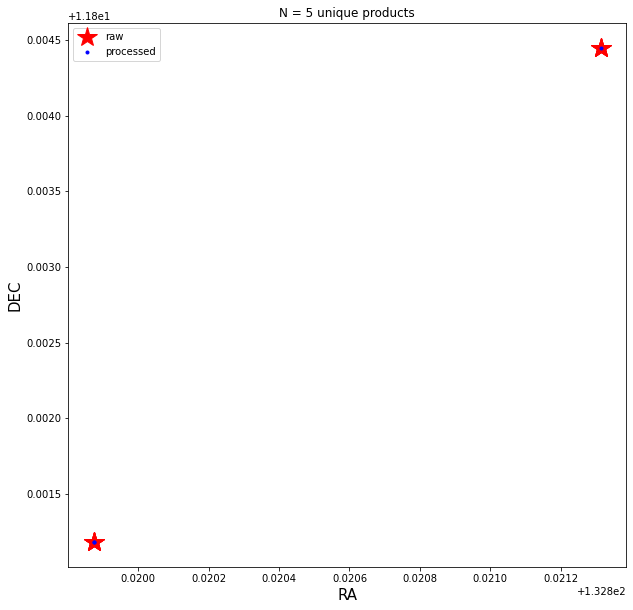

In [21]:
#plot retrieved stars to check region and validate results
plt.figure(figsize=(10,10))
plt.plot(complete_query.RA_raw, complete_query.DEC_raw,'r*', markersize=20,label='raw')
plt.plot(complete_query.RA_pro, complete_query.DEC_pro,'b.',label='processed')
plt.legend()
plt.xlabel('RA',fontsize=15)
plt.ylabel('DEC',fontsize=15)
plt.title(f"N = {len(unique_stars)} unique products")
plt.show()

## Cleaning up the data

As the PK values are generated based on the observation time for each raw file, as a result we can recreate the values using the string pk values and convert them to date/time. ADQL query doesn't support the SQL 'convert' function, as a result we use pandas to apply the filtering for the dates. 

In [22]:
#generate timestamps based on dates passed for post 
obs_night_beg = pd.to_datetime(obs_night_beg,format='%Y-%m-%dT%H:%M:%S.%f')
obs_night_end = pd.to_datetime(obs_night_end,format='%Y-%m-%dT%H:%M:%S.%f')

#generate timestamp using the PK values
obs_datetime=[]
for i in complete_query.pk:
    temp = i.split(".")
    obs_datetime.append(temp[1]+'.'+temp[2])    
complete_query["observed_datetime"] =pd.to_datetime(obs_datetime,format='%Y-%m-%dT%H:%M:%S.%f')    


if obs_night_beg or obs_night_end:
    top = complete_query[ (complete_query.observed_datetime >= obs_night_beg) & (complete_query.observed_datetime<=obs_night_end) ]   
else: top = complete_query.copy()    
top.sample()    

,tpl_start,pk,snr,instrument_pro,RA_pro,DEC_pro,instrument_raw,RA_raw,DEC_raw,VO_identifier_raw,VO_identifier_pro,access_url_pro,access_url_raw,technology_raw,technology_pro,product_type_raw,product_type_pro,waveband_pro,waveband_raw,data_type_raw,obs_mode,name_raw_file,observed_datetime
1,2002-11-29T06:22:36,UVES.2002-11-29T06:23:58.687,NaN,NaN,NaN,NaN,UVES,132.821314,11.80445,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?UVES.2002-11-29T06:23:58.687,NaN,NaN,https://dataportal.eso.org/dataportal_new/file/UVES.2002-11-29T06:23:58.687,ECHELLE,NaN,SCIENCE,NaN,NaN,blue,"OBJECT,POINT",s,UVES_DIC2B_OBS333_0002.fits,2002-11-29 06:23:58.687


In [23]:
top.dtypes

tpl_start                    object
pk                           object
snr                         float64
instrument_pro               object
RA_pro                      float64
DEC_pro                     float64
instrument_raw               object
RA_raw                      float64
DEC_raw                     float64
VO_identifier_raw            object
VO_identifier_pro            object
access_url_pro               object
access_url_raw               object
technology_raw               object
technology_pro               object
product_type_raw             object
product_type_pro             object
waveband_pro                 object
waveband_raw                 object
data_type_raw                object
obs_mode                     object
name_raw_file                object
observed_datetime    datetime64[ns]
dtype: object

you can see now that the **observed_datetime** is *datetime64[ns]*

### Separating the sets 

In [24]:
#clean processed data
accepted_pro = top[(top.VO_identifier_pro.notna())]
accepted_pro = accepted_pro[accepted_pro.product_type_pro.isin(process_product_selection)] #select processed product types
accepted_pro = accepted_pro[accepted_pro.waveband_pro.isin(wave_selection)] #select waveband arm
accepted_pro['processing'] = len(accepted_pro)*['process']
accepted_pro.index=range(len(accepted_pro))
accepted_pro.sample()

,tpl_start,pk,snr,instrument_pro,RA_pro,DEC_pro,instrument_raw,RA_raw,DEC_raw,VO_identifier_raw,VO_identifier_pro,access_url_pro,access_url_raw,technology_raw,technology_pro,product_type_raw,product_type_pro,waveband_pro,waveband_raw,data_type_raw,obs_mode,name_raw_file,observed_datetime,processing
0,2002-11-29T06:22:36,UVES.2002-11-29T06:23:58.310,126.1,UVES,132.821314,11.80445,UVES,132.821314,11.80445,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?UVES.2002-11-29T06:23:58.310,ivo://eso.org/origfile?UV_SOBF_126444_2002-11-29T06:23:58.310_RED860d2_1x1_08.fits,http://archive.eso.org/datalink/links?ID=ADP.2020-08-10T13:26:53.534,https://dataportal.eso.org/dataportal_new/file/UVES.2002-11-29T06:23:58.310,ECHELLE,ECHELLE,SCIENCE,stacked,red,red,"OBJECT,POINT",s,UVES_DIC2R_OBS333_0002.fits,2002-11-29 06:23:58.310,process


We selected the processed rows based on the previously defined selection criteria of product type and waveband arm for both processed and raw data. But the as some of the raw data have their corresponding processed data, then we don't need to do them again. So we select only the raw files that have a selected data. 

The Venn diagram below describes the sets that we want. 

<img src="drawing.png">


In [25]:
#clean raw data
accepted_raw = top[top.VO_identifier_raw.notna() ]
accepted_raw = accepted_raw[accepted_raw.waveband_raw.isin(wave_selection)] #select waveband arm
accepted_raw['processing'] = len(accepted_raw)*['raw']
accepted_raw.sample()

,tpl_start,pk,snr,instrument_pro,RA_pro,DEC_pro,instrument_raw,RA_raw,DEC_raw,VO_identifier_raw,VO_identifier_pro,access_url_pro,access_url_raw,technology_raw,technology_pro,product_type_raw,product_type_pro,waveband_pro,waveband_raw,data_type_raw,obs_mode,name_raw_file,observed_datetime,processing
2,2002-11-29T06:22:36,UVES.2002-11-29T06:34:50.047,NaN,NaN,NaN,NaN,UVES,132.821314,11.80445,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?UVES.2002-11-29T06:34:50.047,NaN,NaN,https://dataportal.eso.org/dataportal_new/file/UVES.2002-11-29T06:34:50.047,ECHELLE,NaN,SCIENCE,NaN,NaN,red,"OBJECT,POINT",s,UVES_DIC2R_OBS333_0003.fits,2002-11-29 06:34:50.047,raw


In [26]:
#creating sets
pro = set(accepted_pro.pk)
raw =  set(accepted_raw.pk)
raw_unprocess = raw - pro.intersection(raw) #  A - A and B


#select the raw files which are not processed
accepted_raw_unprocess = top[top.pk.isin(list(raw_unprocess)) ]
accepted_raw_unprocess['processing'] = len(accepted_raw_unprocess)*['raw']
accepted_raw_unprocess.index = range(len(accepted_raw_unprocess))
accepted_raw_unprocess.sample()

,tpl_start,pk,snr,instrument_pro,RA_pro,DEC_pro,instrument_raw,RA_raw,DEC_raw,VO_identifier_raw,VO_identifier_pro,access_url_pro,access_url_raw,technology_raw,technology_pro,product_type_raw,product_type_pro,waveband_pro,waveband_raw,data_type_raw,obs_mode,name_raw_file,observed_datetime,processing
3,2002-12-31T05:27:04,UVES.2002-12-31T06:20:01.168,NaN,NaN,NaN,NaN,UVES,132.819874,11.80118,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?UVES.2002-12-31T06:20:01.168,NaN,NaN,https://dataportal.eso.org/dataportal_new/file/UVES.2002-12-31T06:20:01.168,ECHELLE,NaN,SCIENCE,NaN,NaN,red,"OBJECT,POINT",s,UVES_DIC1R_OBS365_0023.fits,2002-12-31 06:20:01.168,raw


## Download the raw data

In [27]:
print("[INFO]: Downloading Raw data")
counter=1
status_raw=[]
for i in range(len(accepted_raw_unprocess)):
    url_fits = accepted_raw_unprocess.access_url_raw.iloc[i]
    try:
        name=download_raw(url_fits,save_directory_raw)
        print(f"[INFO]: Downloading ->{counter}/{len(accepted_raw_unprocess)} -> SUCCESS" )
        status_raw.append(name)
    
    except KeyboardInterrupt:
        sys.exit()
    
    except: 
        print(f"[INFO]: Downloading ->{counter}/{len(accepted_raw_unprocess)} -> FAILED: No access"  ) 
        status_raw.append("Not Downloaded")

    counter = counter + 1 
    
    

accepted_raw_unprocess['local_file_name']= status_raw
accepted_raw_unprocess.sample()

[INFO]: Downloading Raw data
[INFO]: Downloading ->1/4 -> SUCCESS
[INFO]: Downloading ->2/4 -> SUCCESS
[INFO]: Downloading ->3/4 -> SUCCESS
[INFO]: Downloading ->4/4 -> SUCCESS


,tpl_start,pk,snr,instrument_pro,RA_pro,DEC_pro,instrument_raw,RA_raw,DEC_raw,VO_identifier_raw,VO_identifier_pro,access_url_pro,access_url_raw,technology_raw,technology_pro,product_type_raw,product_type_pro,waveband_pro,waveband_raw,data_type_raw,obs_mode,name_raw_file,observed_datetime,processing,local_file_name
0,2002-11-29T06:22:36,UVES.2002-11-29T06:34:50.047,NaN,NaN,NaN,NaN,UVES,132.821314,11.80445,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?UVES.2002-11-29T06:34:50.047,NaN,NaN,https://dataportal.eso.org/dataportal_new/file/UVES.2002-11-29T06:34:50.047,ECHELLE,NaN,SCIENCE,NaN,NaN,red,"OBJECT,POINT",s,UVES_DIC2R_OBS333_0003.fits,2002-11-29 06:34:50.047,raw,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:22-886024_UVES.2002-11-29T06:34:50.047.fits


### Extracting the central wavelength, bin size and slit size from headers

In [28]:
#RAW DATA
info={ k: []  for k in fits_items}
for i  in accepted_raw_unprocess.local_file_name:
    if i!="Not Downloaded":
        file = fits.open(i)
        header=file[0].header
        for j in fits_items:
            try:
                temp = info[j]
                temp.append(header[j])
                info[j] = temp
            
            except:
                temp = info[j]
                temp.append(np.nan)
                info[j] = temp

            
        
for i in fits_items:          
    accepted_raw_unprocess[i] = info[i]  

save the results of the raw data for later use

In [29]:
accepted_raw_unprocess.to_csv(save_directory_global+'/raw_summary_'+note+'.csv')

## Download the processed data

In [30]:
status_pro=[]
counter=1
for i in range(len(accepted_pro)):
    id_fits = accepted_pro.access_url_pro.iloc[i].split("=")[1]
    try:
        name=download_process(id_fits,save_directory_process)
        print(f"[INFO]: Downloading ->{counter}/{len(accepted_pro)} -> SUCCESS" ) 
        status_pro.append(name)
    except: 
        print(f"[INFO]: Downloading ->{counter}/{len(accepted_pro)} -> FAILED: No access"  ) 
        status_pro.append("Not Downloaded")
        
    counter = counter + 1    

print("\n")

accepted_pro['local_file_name']= status_pro

[INFO]: Downloading ->1/2 -> SUCCESS
[INFO]: Downloading ->2/2 -> SUCCESS




### Extracting the central wavelength, bin size and slit size from headers

In [31]:
info={ k: []  for k in fits_items}
for i  in accepted_pro.local_file_name:
    if i!="Not Downloaded":
        file = fits.open(i)
        header=file[0].header
        for j in fits_items:
            try:
                temp = info[j]
                temp.append(header[j])
                info[j] = temp
            
            except:
                temp = info[j]
                temp.append(np.nan)
                info[j] = temp

            
for i in fits_items:          
    accepted_pro[i] = info[i]  

save the results of the processed data 

In [32]:
accepted_pro.to_csv(save_directory_global+'/process_summary_'+note+'.csv')

## MOS results extraction

The MOS contains tables associated to "Multiple Objects". Which we will extract and save. We will use those RA and DEC values later on to cross match with other databases such as Simbad, Gaia , and 2MASS

In [33]:
mos = accepted_raw_unprocess[accepted_raw_unprocess.technology_raw=="MOS"]
results=pd.DataFrame()

if len(mos)>0:
    for index,name in enumerate(mos.local_file_name):
        
        try: 
            fits_file = fits.open(name)
            t = Table.read(fits_file,hdu=mos_table_name,format='fits') 
            t = decode_pandas(t.to_pandas())
            t ['local_file_name'] = len(t)*[name]   
            t ['pk'] = len(t)*[mos.pk.iloc[index]]    
            results=results.append(t)
            print(f'{name} -> extraction successful')
        except:
            print(f'{name} -> FAILED')
                    
    
    accepted_mos = results[results.TYPE == mos_type]
    accepted_mos.to_csv(save_directory_global+'/MOS_summary_'+note+'.csv')



else: 
    accepted_mos = pd.DataFrame(data=None,columns=['pk','RA','DEC','local_file_name'])
    print("\n")
    print("[INFO]: No MOS files retrieved")






[INFO]: No MOS files retrieved


In [34]:
accepted_mos

,pk,RA,DEC,local_file_name


## Cross match data

### Create unique database of objects in ESO-archive

We first start by creating a unique set of identifiers for each object by extracting from raw, processedm, and MOS databases: The PKs, coorindates, filenames, and processing type. We will also calculate the galactic latitudes and longitudes based on the coordinates of eso-archive

In [35]:
mos_clean = accepted_mos[['pk','RA','DEC','local_file_name']]
mos_clean['processing'] = len(mos_clean)*['raw_MOS']
pro_clean = accepted_pro[['pk','RA_pro','DEC_pro','processing','local_file_name']].rename({'RA_pro':'RA','DEC_pro':'DEC'},axis=1)
raw_clean = accepted_raw_unprocess[['pk','RA_raw','DEC_raw','processing','local_file_name']]\
    [accepted_raw_unprocess.technology_raw!="MOS"].rename({'RA_raw':'RA','DEC_raw':'DEC'},axis=1)


data = mos_clean.append(pro_clean)
data = data.append(raw_clean) 

#%%
if len(data) == len(data.drop_duplicates())  : print('[INFO]: No duplicates')
else: print('[INFO]: Cautions! ->  Duplicates exits')


#get galactic coordinates
coords = SkyCoord(data.RA*u.deg, data.DEC*u.deg, frame='icrs')
coords = coords.galactic
data['l_eso'] = coords.l.to_value()
data['b_eso'] = coords.b.to_value()
data.head()

[INFO]: No duplicates


,pk,RA,DEC,local_file_name,processing,l_eso,b_eso
0,UVES.2002-11-29T06:23:58.310,132.821314,11.80445,/home/sako/Desktop/M 67/Processed/2021-03-17 17:15:21-238123_ADP.2020-08-10T13:26:53.534.fits,process,215.689468,31.894849
1,UVES.2002-12-31T05:28:14.907,132.819874,11.80118,/home/sako/Desktop/M 67/Processed/2021-03-17 17:15:25-205415_ADP.2020-08-10T14:27:17.347.fits,process,215.692271,31.892200
0,UVES.2002-11-29T06:34:50.047,132.821314,11.80445,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:22-886024_UVES.2002-11-29T06:34:50.047.fits,raw,215.689468,31.894849
1,UVES.2002-11-29T06:45:42.390,132.821314,11.80445,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:37-004683_UVES.2002-11-29T06:45:42.390.fits,raw,215.689468,31.894849
2,UVES.2002-12-31T05:54:08.797,132.819874,11.80118,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:51-272070_UVES.2002-12-31T05:54:08.797.fits,raw,215.692271,31.892200


### Cross match with Simbad database

We cross match the **data** variable with the Simbad database using the CDS cross match service. Then we extract the HD, HR, and 2MASS names. The CSD cross match service return several photometeric values but they are not complete. It does not return all the possible flux values. To have a Complete UVBRI photometric data, we do another query to Simbad to extract the missing values.     

In [36]:
df_sim=cross_match(data,'simbad','RA','DEC',rad).rename({'ra':'RA_simbad','dec':'DEC_simbad','angDist':'angDist_simbad'},axis=1) 

#Exclude non-star values
df_sim[df_sim.other_types.str.contains("*",regex=False)]


#gather simbad names
df_sim_names = df_sim[['main_id']].drop_duplicates().dropna()

names_all = get_simbad_names(df_sim_names.main_id)
names_HD = search_simbad_names(names_all,'HD')
names_HR = search_simbad_names(names_all,'HR')
names_2MASS = search_simbad_names(names_all,'2MASS')

df_sim_names['HD_names']=[ names_HD[i]  for i in df_sim_names.main_id  ]
df_sim_names['HR_names']=[names_HR[i]  for i in df_sim_names.main_id  ]
df_sim_names['2MASS_names']=[names_2MASS[i]  for i in df_sim_names.main_id  ]

df_sim = pd.merge(df_sim,df_sim_names,how='outer',on=['main_id'])
df_sim = pd.merge(df_sim,data,how='outer',on=['pk','l_eso','b_eso','RA','DEC','local_file_name','processing'])


#gather UBVRI
Simbad.add_votable_fields('flux(U)','flux(I)')
df_UBVRI = Simbad.query_objects(list(df_sim.main_id.dropna().unique()))
df_UBVRI = decode_pandas(df_UBVRI.to_pandas())[["MAIN_ID","FLUX_U","FLUX_I"]].rename({"MAIN_ID":"main_id",'FLUX_U':'U','FLUX_I':'I'},axis=1)
df_sim = pd.merge(df_sim,df_UBVRI,how='outer',on=['main_id'])


df_sim.to_csv(save_directory_global +f"/simbad_{rad}_arc.csv")


In [42]:
#save simbad cross match results
df_sim.to_csv(save_directory_global +f"/simbad_{rad}_arc.csv")
df_sim.head()

,angDist_simbad,pk,RA,DEC,local_file_name,processing,l_eso,b_eso,main_id,RA_simbad,DEC_simbad,coo_err_maj,coo_err_min,coo_err_angle,nbref,ra_sexa,dec_sexa,main_type,other_types,radvel,redshift,sp_type,morph_type,plx,pmra,pmdec,size_maj,size_min,size_angle,B,V,R,J,H,K,u,g,r,i,z,HD_names,HR_names,2MASS_names,U,I
0,0.276560,UVES.2002-11-29T06:23:58.310,132.821314,11.80445,/home/sako/Desktop/M 67/Processed/2021-03-17 17:15:21-238123_ADP.2020-08-10T13:26:53.534.fits,process,215.689468,31.894849,NGC 2682 105,132.821249,11.804494,0.0,0.0,90.0,127.0,08 51 17.09987,+11 48 16.1773,RGB*,RG*|*iC|* |IR |*,33.6,0.000112,K2III,<NA>,1.1358,-11.43,-3.29,<NA>,<NA>,<NA>,11.554,10.316,9.942,8.14,7.526,7.385,<NA>,10.996,9.939,9.621,<NA>,NaN,NaN,2MASS J08511710+1148160,NaN,9.07
1,0.276213,UVES.2002-11-29T06:34:50.047,132.821314,11.80445,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:22-886024_UVES.2002-11-29T06:34:50.047.fits,raw,215.689468,31.894849,NGC 2682 105,132.821249,11.804494,0.0,0.0,90.0,127.0,08 51 17.09987,+11 48 16.1773,RGB*,RG*|*iC|* |IR |*,33.6,0.000112,K2III,<NA>,1.1358,-11.43,-3.29,<NA>,<NA>,<NA>,11.554,10.316,9.942,8.14,7.526,7.385,<NA>,10.996,9.939,9.621,<NA>,NaN,NaN,2MASS J08511710+1148160,NaN,9.07
2,0.276213,UVES.2002-11-29T06:45:42.390,132.821314,11.80445,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:37-004683_UVES.2002-11-29T06:45:42.390.fits,raw,215.689468,31.894849,NGC 2682 105,132.821249,11.804494,0.0,0.0,90.0,127.0,08 51 17.09987,+11 48 16.1773,RGB*,RG*|*iC|* |IR |*,33.6,0.000112,K2III,<NA>,1.1358,-11.43,-3.29,<NA>,<NA>,<NA>,11.554,10.316,9.942,8.14,7.526,7.385,<NA>,10.996,9.939,9.621,<NA>,NaN,NaN,2MASS J08511710+1148160,NaN,9.07
3,NaN,UVES.2002-12-31T05:28:14.907,132.819874,11.80118,/home/sako/Desktop/M 67/Processed/2021-03-17 17:15:25-205415_ADP.2020-08-10T14:27:17.347.fits,process,215.692271,31.892200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
4,NaN,UVES.2002-12-31T05:54:08.797,132.819874,11.80118,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:51-272070_UVES.2002-12-31T05:54:08.797.fits,raw,215.692271,31.892200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN


### Cross match with 2MASS to get complete data

In [38]:
df_2mass=cross_match(data,'vizier:II/246/out','RA','DEC',rad)       
df_2mass = pd.merge(df_2mass,data,how='outer',on=['pk','l_eso','b_eso','RA','DEC','local_file_name','processing']) 

In [43]:
#save 2MASS results
df_2mass.to_csv(save_directory_global +f"/2mass_{rad}_arc.csv")
df_2mass.head()

,angDist,pk,RA,DEC,local_file_name,processing,l_eso,b_eso,2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
0,0.204061,UVES.2002-11-29T06:23:58.310,132.821314,11.80445,/home/sako/Desktop/M 67/Processed/2021-03-17 17:15:21-238123_ADP.2020-08-10T13:26:53.534.fits,process,215.689468,31.894849,08511710+1148160,132.821257,11.80446,0.07,0.07,90.0,8.14,7.526,7.385,0.027,0.018,0.021,AAA,111.0,0.0,2.450769e+06
1,0.203645,UVES.2002-11-29T06:34:50.047,132.821314,11.80445,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:22-886024_UVES.2002-11-29T06:34:50.047.fits,raw,215.689468,31.894849,08511710+1148160,132.821257,11.80446,0.07,0.07,90.0,8.14,7.526,7.385,0.027,0.018,0.021,AAA,111.0,0.0,2.450769e+06
2,0.203645,UVES.2002-11-29T06:45:42.390,132.821314,11.80445,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:37-004683_UVES.2002-11-29T06:45:42.390.fits,raw,215.689468,31.894849,08511710+1148160,132.821257,11.80446,0.07,0.07,90.0,8.14,7.526,7.385,0.027,0.018,0.021,AAA,111.0,0.0,2.450769e+06
3,NaN,UVES.2002-12-31T05:28:14.907,132.819874,11.80118,/home/sako/Desktop/M 67/Processed/2021-03-17 17:15:25-205415_ADP.2020-08-10T14:27:17.347.fits,process,215.692271,31.892200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,UVES.2002-12-31T05:54:08.797,132.819874,11.80118,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:51-272070_UVES.2002-12-31T05:54:08.797.fits,raw,215.692271,31.892200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cross match with GAIA erdr3 

Vizier has integrated the gaia erdr3 with it's query system. Not it has become easier to use CDS cross match service to get the matches. But yet again it is return an incomplete dataset. As the cross match service retrieves missing columns, we access the original catalog and query the rows which have the source ID values that the cross match retrieved.  

In [40]:
df_gaia_pre=cross_match(data,'vizier:I/350/gaiaedr3','RA','DEC', rad)       
df_gaia_pre = pd.merge(df_gaia_pre,data,how='outer',on=['pk','l_eso','b_eso','RA','DEC','local_file_name','processing']) 
df_gaia_pre = df_gaia_pre[['angDist','pk','l_eso','b_eso','RA','DEC','local_file_name','processing','source_id']]
df_gaia_complete=query_gaia_id(list(df_gaia_pre.source_id.dropna().astype(int).unique()))

df_gaia = pd.merge(df_gaia_complete,df_gaia_pre,how='outer',on=["source_id"])

INFO: Query finished. [astroquery.utils.tap.core]


In [44]:
df_gaia.to_csv(save_directory_global +f"/gaia_{rad}_arc.csv")
df_gaia.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,angDist,pk,l_eso,b_eso,RA,DEC,local_file_name,processing
0,1.636043e+18,Gaia EDR3 604917594995372544,6.049176e+17,320256827.0,2016.0,132.821198,0.013688,11.804479,0.007112,1.162057,0.016479,70.517487,11.784287,-11.379391,0.017993,-3.062499,0.011857,-0.237511,-0.04186,-0.037079,0.017261,0.114808,0.024837,-0.027954,0.108782,-0.269854,-0.055738,368.0,368.0,364.0,4.0,-1.616359,581.757568,0.049816,3.460764,31.0,False,1.434839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,17.0,0.024955,46.0,8.0,0.0,0.076463,8.913486,0.0,0.0,0.939379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,366.0,2.023868e+06,303.2164,6674.665527,9.921911,38.0,815934.059606,322.78241,2527.814453,10.559404,39.0,1.720873e+06,303.346008,5672.970703,9.158524,0.0,0.0,0.0,0.0,0.0,1.253445,1.400881,0.637493,0.763388,34.037579,0.197965,6.0,4500.0,2.0,0.0,215.689373,31.894756,131.955205,-5.618185,0.275199,UVES.2002-11-29T06:23:58.310,215.689468,31.894849,132.821314,11.80445,/home/sako/Desktop/M 67/Processed/2021-03-17 17:15:21-238123_ADP.2020-08-10T13:26:53.534.fits,process
1,1.636043e+18,Gaia EDR3 604917594995372544,6.049176e+17,320256827.0,2016.0,132.821198,0.013688,11.804479,0.007112,1.162057,0.016479,70.517487,11.784287,-11.379391,0.017993,-3.062499,0.011857,-0.237511,-0.04186,-0.037079,0.017261,0.114808,0.024837,-0.027954,0.108782,-0.269854,-0.055738,368.0,368.0,364.0,4.0,-1.616359,581.757568,0.049816,3.460764,31.0,False,1.434839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,17.0,0.024955,46.0,8.0,0.0,0.076463,8.913486,0.0,0.0,0.939379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,366.0,2.023868e+06,303.2164,6674.665527,9.921911,38.0,815934.059606,322.78241,2527.814453,10.559404,39.0,1.720873e+06,303.346008,5672.970703,9.158524,0.0,0.0,0.0,0.0,0.0,1.253445,1.400881,0.637493,0.763388,34.037579,0.197965,6.0,4500.0,2.0,0.0,215.689373,31.894756,131.955205,-5.618185,0.274848,UVES.2002-11-29T06:34:50.047,215.689468,31.894849,132.821314,11.80445,/home/sako/Desktop/M 67/Raw/2021-03-17 17:14:22-886024_UVES.2002-11-29T06:34:50.047.fits,raw
2,1.636043e+18,Gaia EDR3 604917594995372544,6.049176e+17,320256827.0,2016.0,132.821198,0.013688,11.804479,0.007112,1.162057,0.016479,70.517487,11.784287,-11.379391,0.017993,-3.062499,0.011857,-0.237511,-0.041